# Auto detect PDF fields

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Prepare Data

    - split the data into features and labels
    - filling missing values
    - feature encoding

In [2]:
markup_data = pd.read_csv("training.csv")

In [3]:
# fill missng values
markup_data["FieldCode"].fillna("N/A", inplace=True)
markup_data["Prefix"].fillna("N/A", inplace=True)
markup_data["Suffix"].fillna("N/A", inplace=True)

In [4]:
markup_data.dropna(inplace=True)
markup_data.columns

Index(['FileName', 'PageNum', 'LineLeft', 'LineRight', 'LineTop', 'LineBottom',
       'LineWidth', 'TopElement', 'LeftPadding', 'RightPadding', 'HasCentLine',
       'HasComboLine', 'FieldWidth', 'FieldHeight', 'Prefix', 'PrefixGap',
       'Suffix', 'SuffixGap', 'FieldCode', 'FieldLeft', 'FieldRight',
       'FieldTop', 'FieldBottom', 'IsMarkupField'],
      dtype='object')

In [5]:
markup_data["HasCentLine"] = markup_data["HasCentLine"].astype(int)
markup_data["HasComboLine"] = markup_data["HasComboLine"].astype(int)
markup_data["IsMarkupField"] = markup_data["IsMarkupField"].astype(int)

In [6]:
x = markup_data.drop(labels=['FileName', 'PageNum', 'LineLeft', 'LineRight', 'LineTop', 'LineBottom','Prefix','Suffix','FieldCode','FieldLeft',
   'FieldRight', 'FieldTop', 'FieldBottom', "IsMarkupField"], axis=1)
x.head()

,LineWidth,TopElement,LeftPadding,RightPadding,HasCentLine,HasComboLine,FieldWidth,FieldHeight,PrefixGap,SuffixGap
0,0.0,None,0.0,0.0,0,0,44.270,24.000,0.0,0.0
1,0.0,Line,0.0,0.0,0,0,44.270,14.162,0.0,0.0
2,0.0,Line,0.0,0.0,0,0,50.548,1.905,0.0,0.0
3,0.0,Line,0.0,0.0,0,0,50.548,14.162,0.0,0.0
4,0.5,Text,0.0,0.0,0,0,60.100,61.634,0.0,0.0


In [7]:
len(x)

477649

In [8]:
y = markup_data["IsMarkupField"]

# 2. Modeling

In [9]:
# split the data into training and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((382119, 10), (95530, 10), (382119,), (95530,))

In [10]:
from sklearn.feature_extraction import FeatureHasher
from sklearn.compose import ColumnTransformer

transformer = ColumnTransformer([("hash", FeatureHasher(n_features=2, input_type='string'), 'TopElement')], remainder="passthrough")
transformed_x_train = transformer.fit_transform(x_train)
pd.DataFrame(transformed_x_train).head()

,0,1,2,3,4,5,6,7,8,9,10
0,-1.0,-1.0,0.00,0.0,0.0,0.0,0.0,370.020000,12.0000,0.0,0.0000
1,-1.0,-1.0,0.50,0.0,0.0,0.0,0.0,81.500000,12.0000,0.0,8.4976
2,-1.0,-1.0,0.50,0.0,0.0,0.0,1.0,132.480000,12.0000,0.0,0.0000
3,-1.0,-1.0,0.25,0.0,0.0,0.0,0.0,18.250000,18.0004,0.0,2.8790
4,-1.0,-1.0,0.50,0.0,0.0,0.0,0.0,72.000006,12.0000,0.0,0.0000


In [11]:
transformed_x_test = transformer.fit_transform(x_test)

In [12]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)

In [13]:
model.fit(transformed_x_train, y_train);

In [14]:
model.score(transformed_x_test, y_test)

0.973934889563488

In [15]:
model.predict_proba(transformed_x_test[:10])[:,1]

array([1.  , 0.  , 0.  , 0.3 , 1.  , 0.09, 0.  , 1.  , 1.  , 0.  ])

# 3. Evaluating

In [16]:
y_preds = model.predict(transformed_x_test)

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
accuracy_score(y_test, y_preds)

0.973934889563488

In [19]:
from sklearn.model_selection import cross_val_score
transformed_x = transformer.fit_transform(x)
cv_score = cross_val_score(model, transformed_x, y, cv=5)
np.mean(cv_score)

0.9278989516389247

In [20]:
from sklearn.metrics import roc_curve
y_preds_proba = model.predict_proba(transformed_x_test)[:,1]
y_preds_proba[:10], len(y_preds_proba)
false_positive_rate, true_postive_rate, thresholds = roc_curve(y_test, y_preds_proba)

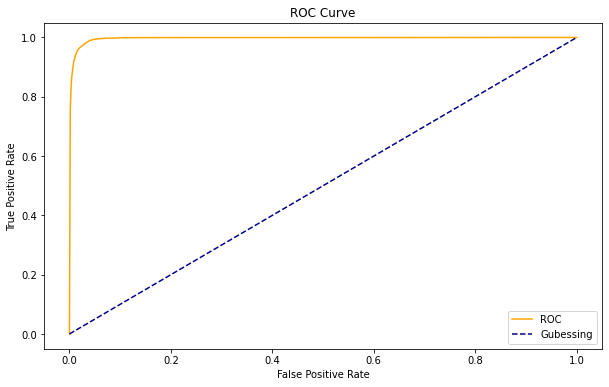

In [21]:
def plot_roc_curve(false_positive_rate, true_postive_rate):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set(title="ROC Curve", xlabel="False Positive Rate", ylabel="True Positive Rate");
    ax.plot(false_positive_rate, true_postive_rate, color="orange", label="ROC")
    ax.plot([0,1], [0,1], label="Gubessing", color="darkblue", linestyle="--")
    ax.legend()
plot_roc_curve(false_positive_rate, true_postive_rate)

In [22]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_preds_proba)

0.9965925770581985

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_preds)
pd.crosstab(y_test, y_preds, rownames=["Actural"], colnames=["Predicted"])

Predicted,0,1
Actural,,
0,48854,1506
1,984,44186


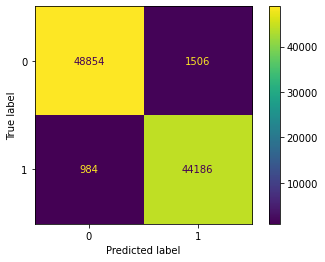

In [24]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, transformed_x_test, y_test);

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     50360
           1       0.97      0.98      0.97     45170

    accuracy                           0.97     95530
   macro avg       0.97      0.97      0.97     95530
weighted avg       0.97      0.97      0.97     95530



# 4. Export the Model

In [26]:
import pickle
pickle.dump(model, open("markup.pkl", "wb"))